In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:

# Define dataset path
data_dir = r"C:\Users\saipr\Food_Contamination\Kitchen Eye"


In [3]:
# Image parameters
img_height, img_width = 224, 224
batch_size = 32


In [4]:
# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)


In [5]:
# Load Data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 460 images belonging to 2 classes.


In [6]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 114 images belonging to 2 classes.


In [41]:
# Load Pretrained MobileNetV2 Model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pretrained layers


In [43]:
# Build Model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Reduces dimensions while retaining features
from tensorflow.keras import regularizers

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output


In [44]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [45]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [46]:

# Callbacks (Early Stopping & Learning Rate Reduction)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [47]:
# Train Model
epochs = 20  # Maximum, but early stopping may stop earlier
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7120 - loss: 2.7433 - val_accuracy: 0.8684 - val_loss: 2.2162 - learning_rate: 0.0010
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9082 - loss: 2.0142 - val_accuracy: 0.8684 - val_loss: 1.8692 - learning_rate: 0.0010
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9390 - loss: 1.6350 - val_accuracy: 0.8860 - val_loss: 1.5932 - learning_rate: 0.0010
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9441 - loss: 1.3346 - val_accuracy: 0.9035 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9408 - loss: 1.1366 - val_accuracy: 0.8860 - val_loss: 1.2006 - learning_rate: 0.0010
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9624 - loss: 0.9510 - val_accuracy: 0.9123 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9573 - loss: 0.8229 - val_accuracy: 

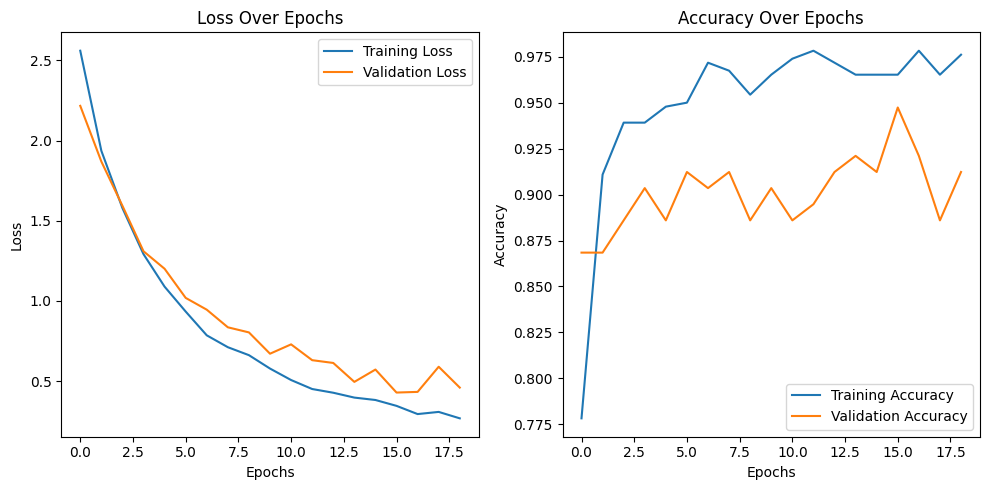

In [48]:
import matplotlib.pyplot as plt

# Assuming model training history is stored in `history`
history = model.history.history

# Plot Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Testing

In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess an image for prediction
def predict_image(image_path):
    # Load image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale

    # Make prediction
    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Contaminated"
    else:
        return "Safe"

# Example usage
image_path = r"C:\Users\saipr\TestContam1.jpg"  # Provide path to your image
result = predict_image(image_path)
print(f"Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Contaminated


In [50]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess an image for prediction
def predict_image(image_path):
    # Load image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale

    # Make prediction
    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Contaminated"
    else:
        return "Safe"

# Example usage
image_path = r"C:\Users\saipr\Good1.jpg"  # Provide path to your image
result = predict_image(image_path)
print(f"Prediction: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Prediction: Safe


## Saving The Model

In [51]:
# Save the model as a .h5 file
model.save(r'C:\Users\saipr\Food_Contamination\model.h5')
